<center>
    <img src="images/personal_logo.png" style="width:50%;"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)


### CelebA AI System

We are developing an AI system using deep learning techniques like Convolutional Autoencoders (CAE), Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with the CelebA dataset. These models will help in facial feature extraction, attribute classification, and image generation. By leveraging these approaches, we aim to enhance face recognition, noise reduction, and synthetic face generation for improved image analysis.

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from tqdm import tqdm   

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary

torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [66]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [67]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [68]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [69]:
!nvidia-smi

Wed Mar 19 16:40:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   29C    P8              10W / 320W |   1468MiB / 16376MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

The data_dir variable holds the path to the dataset directory.   

In [70]:
# train_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
# test_dataset = datasets.CelebA(root='./data', split='test', download=True, transform=transform)  

Path to your dataset folder

In [71]:
data_dir= 'data/celeba'

In [72]:
# Custom Dataset class for loading images from a single folder
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image) # Return a dummy label because the autoencoder does not need labels
        return image, 0

In [73]:
# Load the CelebA dataset from the local folder
dataset = CelebADataset(root_dir=data_dir, transform=None)

In [74]:
# Verify the number of images in dataset
print(f'Number of images in dataset: {len(dataset)}')

Number of images in dataset: 202599


In [75]:
# Function to show real images 
def show_real_images(image_paths, transform=None):
    images = []
    for img_path in image_paths:
        image = Image.open(img_path)
        if transform:
            image = transform(image)
        images.append(np.array(image))  # Convert to numpy array
    
    # Create subplots with a fixed aspect ratio and a layout proportional to the images
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:  # If there's only one image, axes is not an array
        axes = [axes]
    
    for i, img in enumerate(images):
        if img.shape[0] == 3:  
            img = np.transpose(img, (1, 2, 0))  # Convert from CHW to HWC format
        
        # Show image
        axes[i].imshow(img)
    
        # Set the axis labels and ticks as proportional
        axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[i].yaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Turn on axis
        axes[i].axis('on')
        
    plt.tight_layout()
    plt.show()

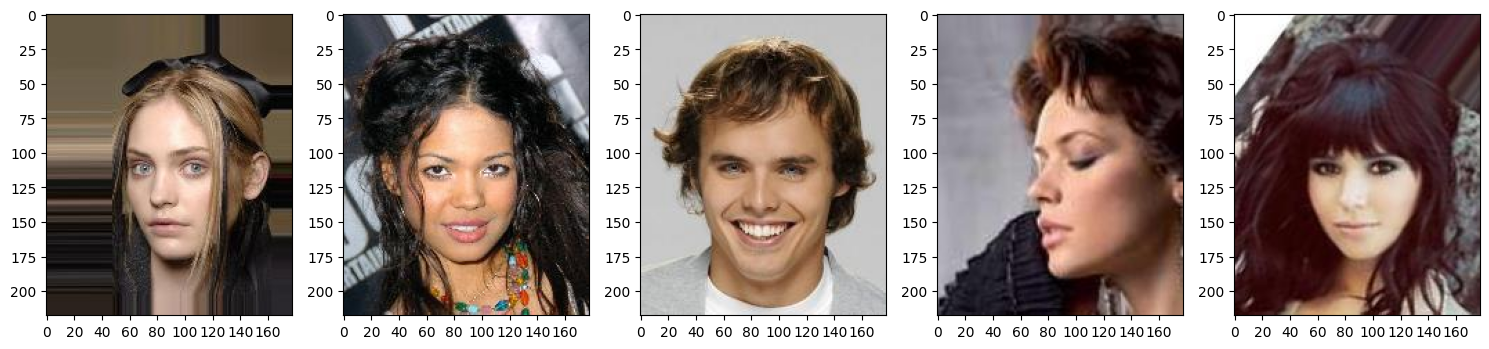

In [76]:
# Example usage of show_real_images
image_paths = [os.path.join(dataset.root_dir, dataset.image_files[i]) for i in range(5)]
show_real_images(image_paths)

## Vanilla AutoEncoder

Here we define the transformations to be applied to the images in the CelebA dataset.

In [77]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [78]:
# Dataset and DataLoader with transforms
dataset = CelebADataset(root_dir=data_dir, transform=transform)

In [79]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [80]:
# Verify the number of images in each dataset
print(f'Number of images in training dataset: {len(train_dataset)}')
print(f'Number of images in test dataset: {len(test_dataset)}')

Number of images in training dataset: 162079
Number of images in test dataset: 40520


In [81]:
# Create data loaders for the training and test datasets.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=23)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [82]:
# Function to show images from the CelebA dataset
def show_transform_images(loader):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    images = images.numpy()
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(2):
        for j in range(5):
            axes[i, j].imshow(np.transpose(images[i * 5 + j], (1, 2, 0)))
            axes[i, j].set_xticks(np.arange(0, images.shape[2], 32))
            axes[i, j].set_yticks(np.arange(0, images.shape[3], 32))
    plt.show()

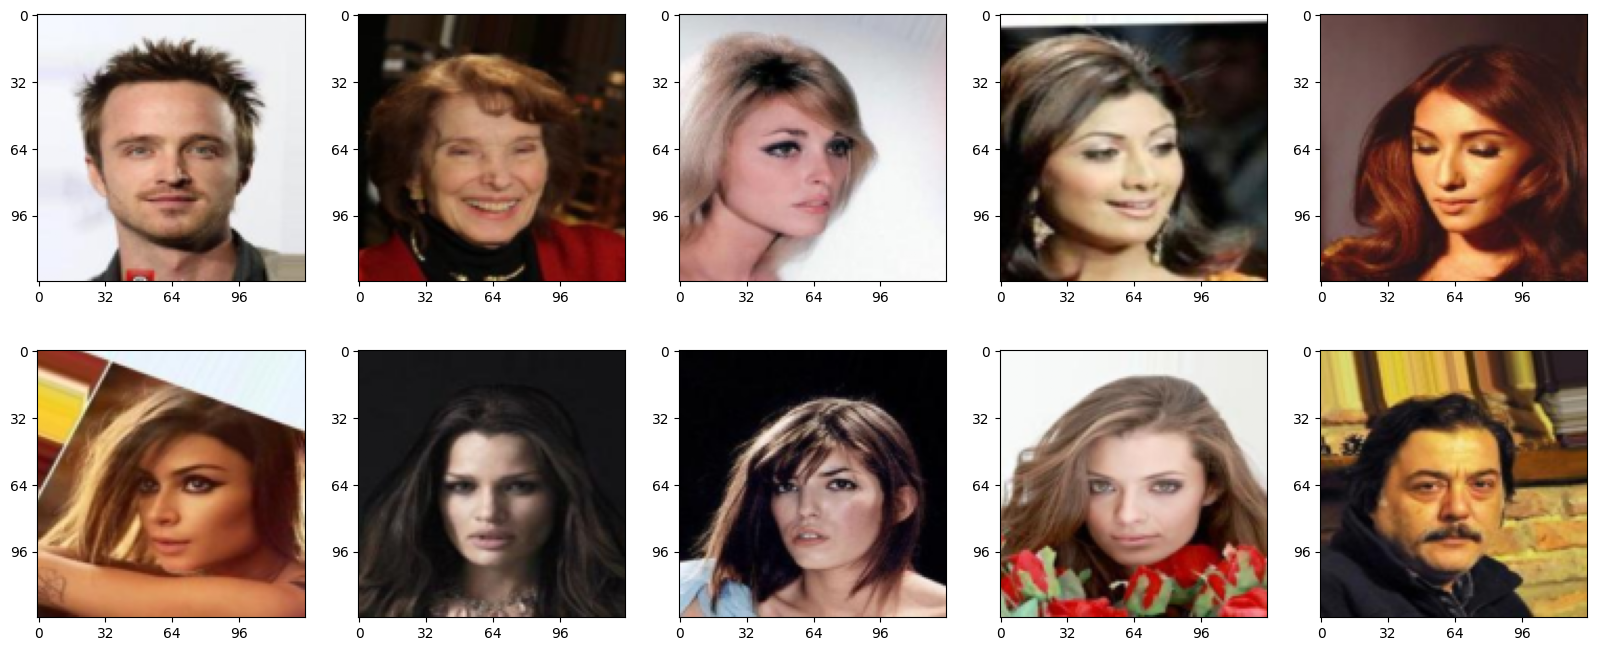

In [83]:
# Show images from the CelebA dataset
show_transform_images(train_loader)

### Define the Vanilla Autoencoder Model

In [49]:
# The latent_dim variable defines the size of the latent space.
latent_dim = 512

In [50]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 128x128 → 64x64
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 64x64 → 32x32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 32x32 → 16x16
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 16x16 → 8x8
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.MaxPool2d(2),  # 8x8 → 4x4
            
            nn.Flatten(),  # Flatten to a 1D vector
            nn.Linear(4 * 4 * 512, latent_dim),  # Match the output to the latent dimension
            nn.SiLU()
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512),
            nn.SiLU(),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.SiLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.SiLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.SiLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 → 64x64
            nn.BatchNorm2d(32),
            nn.SiLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 → 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class VanillaAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VanillaAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [51]:
vanilla_autoencoder = VanillaAutoencoder(latent_dim)

In [52]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_autoencoder.to(device)

VanillaAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): SiLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): SiLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, eps

In [53]:
summary(vanilla_autoencoder, input_size=(3, 128, 128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              SiLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             SiLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
      BatchNorm2d-14          [-1, 256,

### Train Vanilla Autoencoder

We train the vanilla autoencoder for 20 epochs.

In [84]:
# Define the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(vanilla_autoencoder.parameters(), lr=0.001)

In each epoch, we iterate over the training data, perform a forward pass, compute the loss, and update the model parameters.

In [85]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):  
    vanilla_autoencoder.train()
    total_loss = 0  # Track total loss for monitoring

    # Use tqdm to add a progress bar to the training
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for img, _ in tepoch:
            img = img.to(device).float()  # Ensure images are float
            
            optimizer.zero_grad()
            output = vanilla_autoencoder(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulate batch loss

            # Update progress bar with the loss value
            tepoch.set_postfix(loss=loss.item())

    # Average loss per epoch
    avg_loss = total_loss / len(train_loader)  # Compute average loss
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

Epoch 1/50:  23%|██▎       | 590/2533 [00:15<00:51, 37.41batch/s, loss=0.00326]


KeyboardInterrupt: 

In [ ]:
# Save the trained model after training
torch.save(vanilla_autoencoder.state_dict(), 'vanilla_autoencoder.pth')
print("Model saved.")

Model saved.


In [ ]:
vanilla_autoencoder = VanillaAutoencoder(latent_dim).to(device) # Initialize a new instance of the model
vanilla_autoencoder.load_state_dict(torch.load('vanilla_autoencoder.pth')) # Load the saved model weights
vanilla_autoencoder.eval()  # Important: Set the model to evaluation mode
print("Model loaded and ready to use.")

Model loaded and ready to use.


In [63]:
# It takes a data loader and the trained model as input, and displays a few examples of original and reconstructed images.
def show_images(loader, model):
    model.eval()
    with torch.no_grad():
        for img, _ in loader:
            img = img.to(device)
            output = model(img)
            
            # Convertir a numpy
            img = img.cpu().numpy()
            output = output.cpu().numpy()
            
            fig, axes = plt.subplots(2, 5, figsize=(20, 8))
            for i in range(5):
                # Transponer de (C, H, W) a (H, W, C)
                img_transposed = np.transpose(img[i], (1, 2, 0))
                output_transposed = np.transpose(output[i], (1, 2, 0))
                
                # Mostrar las imágenes
                axes[0, i].imshow(img_transposed)
                axes[1, i].imshow(output_transposed)
                
                # Ajustar los ticks
                axes[0, i].set_xticks(np.arange(0, img.shape[2], 32))
                axes[0, i].set_yticks(np.arange(0, img.shape[3], 32))
                axes[1, i].set_xticks(np.arange(0, output.shape[2], 32))
                axes[1, i].set_yticks(np.arange(0, output.shape[3], 32))
                
            plt.show()
            break

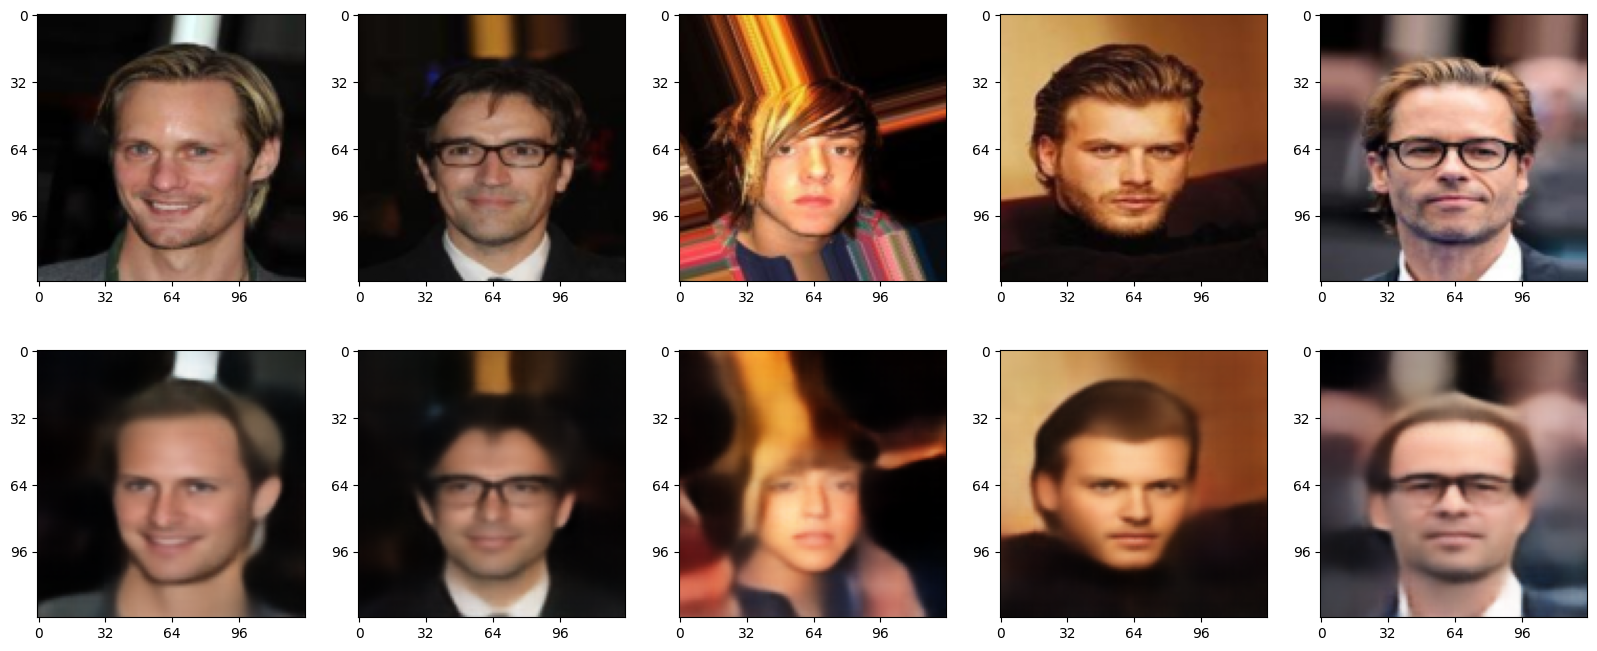

In [64]:
# Compare real images with reconstructed images
show_images(test_loader, vanilla_autoencoder)

In [ ]:
def calculate_anomaly_score(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for img, _ in loader:
            img = img.to(device)
            output = model(img)
            loss = nn.functional.mse_loss(output, img, reduction='none')
            loss = loss.view(loss.size(0), -1).mean(dim=1)
            scores.append(loss.cpu().numpy())
    return np.concatenate(scores)

def evaluate_anomaly_detection(model, real_loader, anomaly_loader):
    real_scores = calculate_anomaly_score(model, real_loader)
    anomaly_scores = calculate_anomaly_score(model, anomaly_loader)
    y_true = np.concatenate([np.zeros_like(real_scores), np.ones_like(anomaly_scores)])
    y_scores = np.concatenate([real_scores, anomaly_scores])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc

real_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
anomaly_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

roc_auc = evaluate_anomaly_detection(vanilla_autoencoder, real_loader, anomaly_loader)
print(f'ROC AUC for anomaly detection: {roc_auc}')

## Denoising AutoEncoder

### Function to add noise to images

This function adds Gaussian noise to the input images.

In [ ]:
# The noise level is controlled by the standard deviation of the Gaussian distribution.
def add_noise(img):
    noise = torch.randn_like(img) * 0.1
    img_noisy = torch.clamp(img + noise, 0., 1.)
    return img_noisy

### Train Denoising Autoencoder

We train the denoising autoencoder for 50 epochs.

In [ ]:
# In each epoch, we add noise to the input images, perform a forward pass, compute the loss, and update the model parameters.
# num_epochs = 20
# for epoch in range(num_epochs):
#     autoencoder.train()
#     total_loss = 0  # Track total loss for monitoring

#     # Use tqdm to add a progress bar to the training
#     with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
#         for img, _ in tepoch:
#             img = img.to(device)
#             img_noisy = add_noise(img)
#             optimizer.zero_grad()
#             output = autoencoder(img_noisy)
#             loss = criterion(output, img)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()  # Accumulate batch loss

#             # Update progress bar with the loss value
#             tepoch.set_postfix(loss=loss.item())

#     # Average loss per epoch
#     avg_loss = total_loss / len(train_loader)  # Compute average loss
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

Epoch 1/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.19batch/s, loss=0.00573]


Epoch 1/20, Loss: 0.005361


Epoch 2/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.45batch/s, loss=0.00521]


Epoch 2/20, Loss: 0.005363


Epoch 3/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.38batch/s, loss=0.00737]


Epoch 3/20, Loss: 0.005362


Epoch 4/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.38batch/s, loss=0.00586]


Epoch 4/20, Loss: 0.005361


Epoch 5/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.21batch/s, loss=0.0059] 


Epoch 5/20, Loss: 0.005360


Epoch 6/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.37batch/s, loss=0.00559]


Epoch 6/20, Loss: 0.005363


Epoch 7/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.29batch/s, loss=0.00532]


Epoch 7/20, Loss: 0.005361


Epoch 8/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.15batch/s, loss=0.00573]


Epoch 8/20, Loss: 0.005363


Epoch 9/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.07batch/s, loss=0.00536]


Epoch 9/20, Loss: 0.005362


Epoch 10/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.00batch/s, loss=0.00583]


Epoch 10/20, Loss: 0.005360


Epoch 11/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.27batch/s, loss=0.00503]


Epoch 11/20, Loss: 0.005361


Epoch 12/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.12batch/s, loss=0.00523]


Epoch 12/20, Loss: 0.005362


Epoch 13/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.58batch/s, loss=0.00702]


Epoch 13/20, Loss: 0.005363


Epoch 14/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.63batch/s, loss=0.00568]


Epoch 14/20, Loss: 0.005362


Epoch 15/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.00batch/s, loss=0.00549]


Epoch 15/20, Loss: 0.005359


Epoch 16/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.14batch/s, loss=0.00613]


Epoch 16/20, Loss: 0.005361


Epoch 17/20: 100%|██████████| 2533/2533 [01:21<00:00, 31.01batch/s, loss=0.00586]


Epoch 17/20, Loss: 0.005362


Epoch 18/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.52batch/s, loss=0.00524]


Epoch 18/20, Loss: 0.005362


Epoch 19/20: 100%|██████████| 2533/2533 [01:22<00:00, 30.86batch/s, loss=0.00529]


Epoch 19/20, Loss: 0.005364


Epoch 20/20: 100%|██████████| 2533/2533 [01:20<00:00, 31.30batch/s, loss=0.00507]

Epoch 20/20, Loss: 0.005364


In [ ]:
# Save the trained denoising autoencoder model after training
# torch.save(autoencoder.state_dict(), 'denoising_autoencoder.pth')  # Save the model's weights to a file
# print("Denoising Autoencoder model saved.")

Denoising Autoencoder model saved.


### Function to show original and reconstructed images

This function visualizes the original and reconstructed images.

In [ ]:
# Load the trained denoising autoencoder model for testing
autoencoder = VanillaAutoencoder(latent_dim).to(device)  # Initialize a new instance of the model
autoencoder.load_state_dict(torch.load('denoising_autoencoder.pth'))  # Load the saved model weights
autoencoder.eval()  # Important: Set the model to evaluation mode
print("Model loaded and ready to use.")

Model loaded and ready to use.


In [ ]:
# It takes a data loader and the trained model as input, and displays a few examples of original and reconstructed images.
def show_images(loader, model):
    model.eval()
    with torch.no_grad():
        for img, _ in loader:
            img = img.to(device)
            output = model(img)
            
            # Convertir a numpy
            img = img.cpu().numpy()
            output = output.cpu().numpy()
            
            fig, axes = plt.subplots(2, 5, figsize=(20, 8))
            for i in range(5):
                # Transponer de (C, H, W) a (H, W, C)
                img_transposed = np.transpose(img[i], (1, 2, 0))
                output_transposed = np.transpose(output[i], (1, 2, 0))
                
                # Mostrar las imágenes
                axes[0, i].imshow(img_transposed)
                axes[1, i].imshow(output_transposed)
                
                # Ajustar los ticks
                axes[0, i].set_xticks(np.arange(0, img.shape[2], 16))
                axes[0, i].set_yticks(np.arange(0, img.shape[3], 16))
                axes[1, i].set_xticks(np.arange(0, output.shape[2], 16))
                axes[1, i].set_yticks(np.arange(0, output.shape[3], 16))
                
            plt.show()
            break

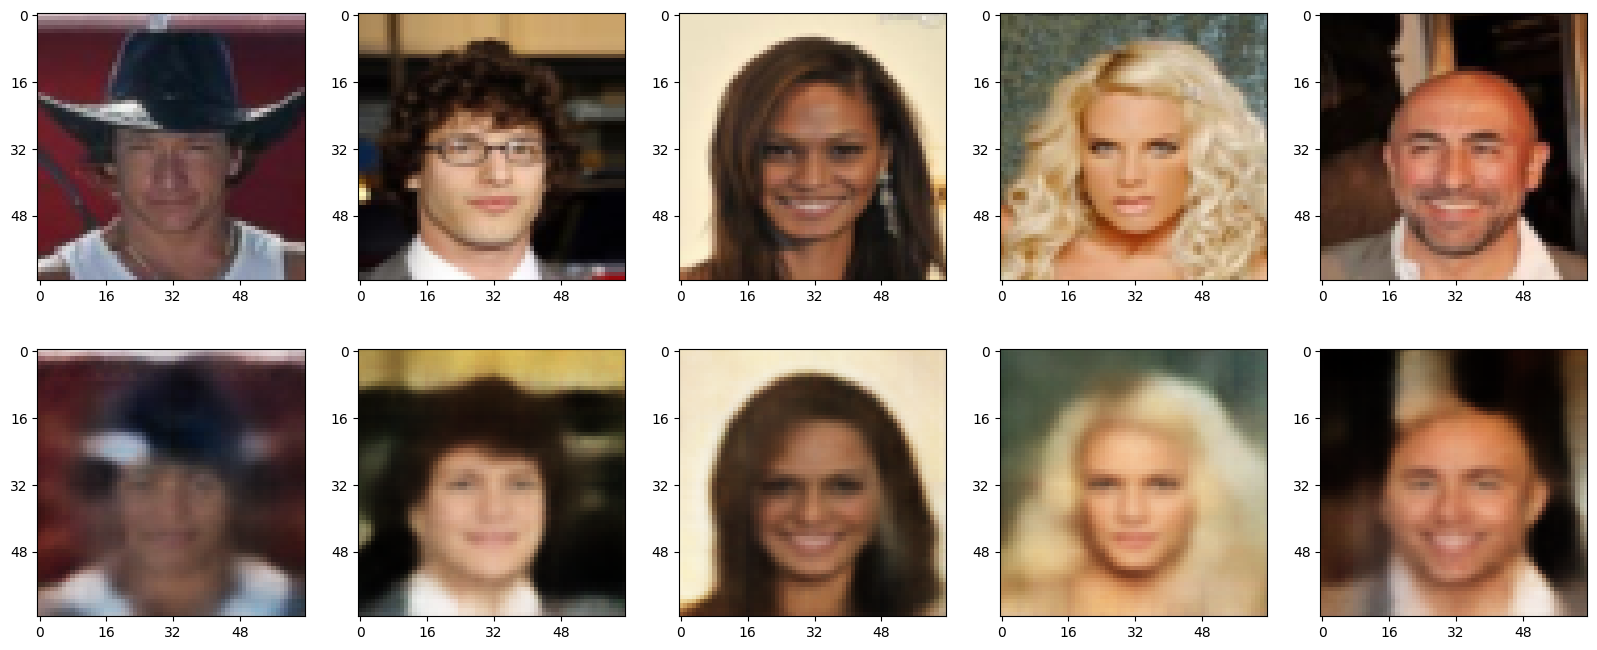

In [ ]:
show_images(test_loader, autoencoder)

## Variational autoencoder (VAE)

## Generative Adversarial Network (GAN)

## Citation

```bibtex
@inproceedings{liu2015faceattributes,
  title = {Deep Learning Face Attributes in the Wild},
  author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},
  booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},
  month = {December},
  year = {2015} 
}